<a href="https://colab.research.google.com/github/namirinz/YSC21-AI_KME/blob/master/Image_Captioning/KME_Image_captioning_luong.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [ ]:
!pip install nami -U -q
!rm -rf .keras

In [ ]:
!pip install -q -U albumentations
!echo "$(pip freeze | grep albumentations) is successfully installed"

     |████████████████████████████████| 81kB 6.9MB/s 
     |████████████████████████████████| 36.7MB 130kB/s 
     |████████████████████████████████| 952kB 52.1MB/s 
albumentations==0.5.1 is successfully installed


In [ ]:
import nami
import time
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm

import albumentations as A

8192/667 [================================================================================================================================================================================================================================================================================================================================================================================] - 0s 0us/step


In [ ]:
!nvidia-smi -L

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-defee54a-25b4-55ed-4967-270636169909)


# Import Dataset

In [ ]:
from nami.datasets.kme import load_data
(image_train, caption_train), (image_test, caption_test) = load_data(test_size = 0.3)

254615552/254610128 [==============================] - 5s 0us/step


In [ ]:
print(image_train.shape)
print(image_test.shape)

(660, 300, 300, 3)
(283, 300, 300, 3)


## Preprocessing Dataset

In [ ]:
from nami.AI.kme_tokenize import Tokenizer
tokenizer = Tokenizer()

In [ ]:
tokenizer.fit_on_texts(caption_train)

In [ ]:
text2seq_train = tokenizer.text_to_sequences(caption_train)
seq2text_train = tokenizer.sequences_to_text(text2seq_train)

In [ ]:
text2seq_test = tokenizer.text_to_sequences(caption_test)
seq2text_test = tokenizer.sequences_to_text(text2seq_test)

## Hyperparameter

In [ ]:
BATCH_SIZE = 16
BUFFER_SIZE = 1000
units = 512
vocab_size = len(tokenizer.word2index)

IMG_SIZE = 300
IMG_SHAPE = (300, 300, 3)

num_steps_train = len(image_train) // BATCH_SIZE
num_steps_test = len(image_test) // BATCH_SIZE

max_length_train = text2seq_train.shape[1]
max_length_test = text2seq_test.shape[1]

encoding_size = 512 # Determines dimension of the encodings of images
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Create Dataset

## Augmentation

In [ ]:
transforms = A.Compose([
            A.ShiftScaleRotate(shift_limit=0.1, scale_limit=[-0.2, 0.2], rotate_limit=45, p=0.9, border_mode=1),
            A.GaussNoise(var_limit=(0, 225), p= 0.9), A.Blur(blur_limit= 3, p= 0.5),
            #HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
            A.Flip(p= 0.5), A.Transpose(p= 0.5),
            A.ToGray(p= 0.7), A.ChannelShuffle(p= 0.5), A.RandomBrightness(limit=(-0.10, 0.0), p= 0.5)
            

        ])

In [ ]:
def aug_fn(image, img_size):
    data = {"image":image}
    aug_data = transforms(**data)
    aug_img = aug_data["image"]
    #aug_img = tf.cast(aug_img/255.0, tf.float32)
    aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
    return aug_img

In [ ]:
def process_data(image, label, img_size=IMG_SIZE):
  aug_img = tf.numpy_function(func=aug_fn, inp=[image, img_size], Tout=tf.float32)
  return aug_img, label

In [ ]:
def set_shapes(img, label, img_shape=IMG_SHAPE):
    img.set_shape(img_shape)
    #label.set_shape([])
    return img, label

## Tf.data.Dataset

In [ ]:
from functools import partial

dataset = tf.data.Dataset.from_tensor_slices((image_train, text2seq_train))
print(dataset)
dataset = dataset.map(partial(process_data, img_size=IMG_SIZE),
                  num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
print(dataset)
dataset = dataset.map(set_shapes, num_parallel_calls=AUTOTUNE).shuffle(1000).batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)
print(dataset)

<TensorSliceDataset shapes: ((300, 300, 3), (58,)), types: (tf.uint8, tf.int32)>
<PrefetchDataset shapes: (<unknown>, (58,)), types: (tf.float32, tf.int32)>
<PrefetchDataset shapes: ((None, 300, 300, 3), (None, 58)), types: (tf.float32, tf.int32)>


In [ ]:
dataset_val = tf.data.Dataset.from_tensor_slices((image_test, text2seq_test)).batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)
dataset_val

<PrefetchDataset shapes: ((None, 300, 300, 3), (None, 32)), types: (tf.uint8, tf.int32)>

## Plot Augmentation

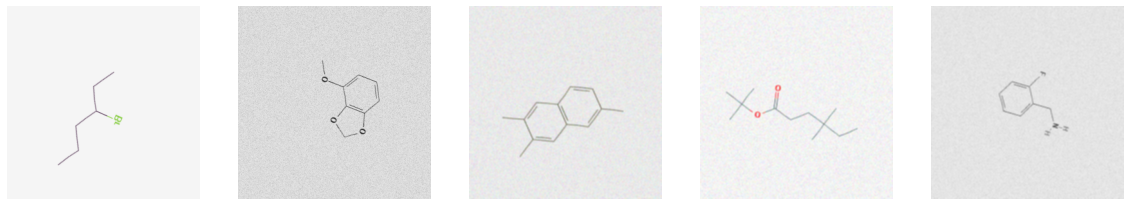

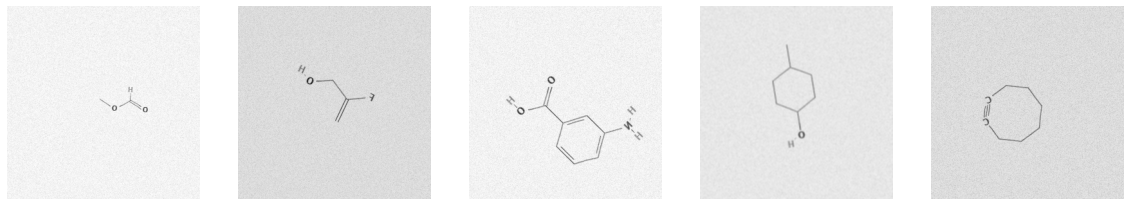

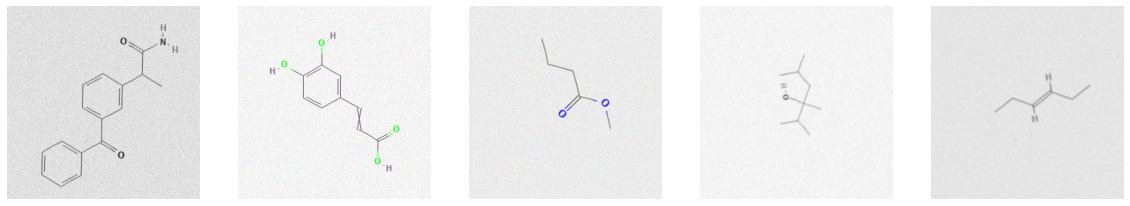

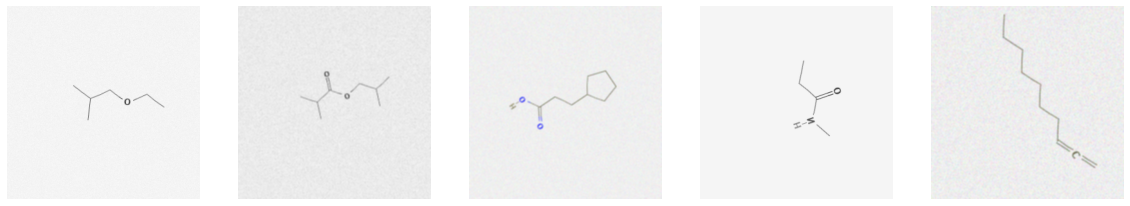

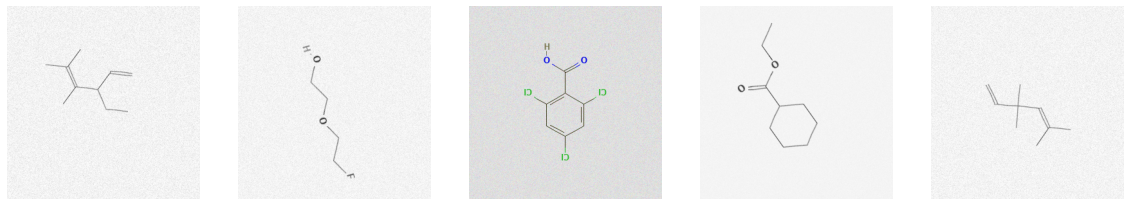

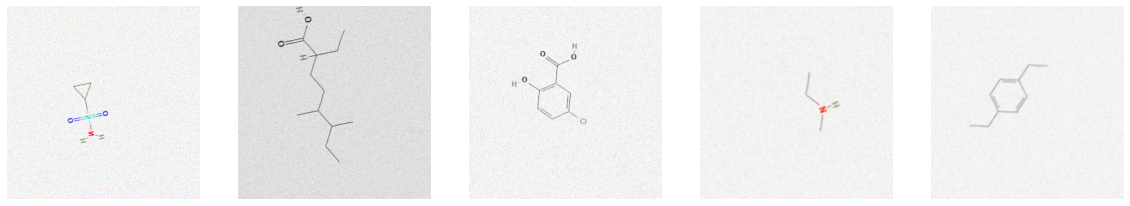

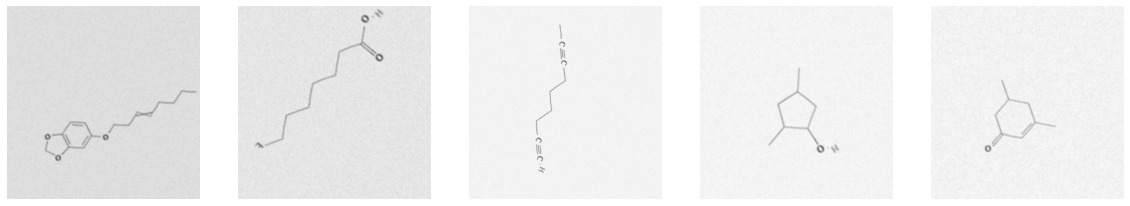

In [ ]:
# Test parameter of ImageDataGenerator
for index, (img, label) in enumerate(dataset):
  plt.figure(figsize=(20, 20))
  for i in range(1, 6):
    plt.subplot(1, 5, i)
    plt.imshow( tf.cast(img[i], tf.uint8) )
    plt.axis('off')
  plt.show()
  if index == 6:
    break

# Model Architecture

## Efficientnet-B7

In [ ]:
from tensorflow.keras.applications.efficientnet import EfficientNetB7

pret_model = EfficientNetB7(include_top = False, weights='imagenet', input_shape=(300, 300, 3))

pret_model.trainable = False

attention_features_shape = 10 * 10
features_shape = 1536

# Xception : [7, 7, 2048]
# InceptionResNetV2 : [5, 5, 1536]
# EfficientNetB0 : [7, 7, 2560]

258080768/258076736 [==============================] - 7s 0us/step


In [ ]:
pret_model.summary()

Model: "efficientnetb7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 300, 300, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 300, 300, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 301, 301, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

## CNN Encoder (Encoder output of feature extraction)

In [ ]:
from tensorflow.keras.models import Sequential

def create_encoder():
  x = tf.keras.layers.Dense(encoding_size,activation='relu',name="encoding_layer")(pret_model.output)
  output = tf.keras.layers.Reshape(target_shape=(attention_features_shape, encoding_size))(x)
  return tf.keras.Model(pret_model.input, output)

In [ ]:
encoder = create_encoder()

In [ ]:
from tensorflow.keras.layers import BatchNormalization, AveragePooling2D

for index, layer in enumerate(encoder.layers):
  if index <= 20 and not isinstance(layer, BatchNormalization):
    layer.trainable = True

In [ ]:
encoder.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 300, 300, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 300, 300, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 301, 301, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

## Luong Attention

In [ ]:
from tensorflow.keras.layers import Dense, Embedding, GRU, LSTM

In [ ]:
def create_attention(features, hidden, method = 'concat'):
  # features(CNN_encoder output) shape == (batch_size, 25, embedding_dim)
  # hidden shape == (batch_size, hidden_size)
  
  # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
  hidden_with_time_axis = tf.expand_dims(hidden, 1)
  
  if method == 'concat':
    attention_hidden_layer = tf.nn.tanh( Dense(units)(features + hidden) )
  elif method == 'general':
    attention_hidden_layer = tf.matmul( features, Dense(units)(hidden), transpose_b=True )
  elif attention_hidden_layer == 'dot':
    attention_hidden_layer = tf.matmul( features, hidden, transpose_b=True )
  
  score = Dense(1)(attention_hidden_layer)
  attention_weights = tf.nn.softmax(score, axis=1)

  context_vector = attention_weights * features
  context_vector = tf.reduce_sum(context_vector, axis=1)
  
  return context_vector, attention_weights

## Create RNN Decoder

In [ ]:
def create_decoder():
  features = tf.keras.layers.Input((attention_features_shape, encoding_size))
  dec_input= tf.keras.layers.Input((1))
  hidden = tf.keras.layers.Input((units))

  embedded = Embedding(vocab_size, encoding_size)(dec_input)

  lstm_output, state = GRU(units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')(embedded, initial_state=[hidden])
 
  context_vector, attention_weights = create_attention(features, lstm_output)

  # embedded shape after concatenation == (batch_size, 1, encoding_size + hidden_size)
  output = tf.concat([context_vector, tf.squeeze(embedded, 1)], axis = -1)
  
  # shape == (batch_size, hidden_size)
  output = Dense(units, activation='tanh')(output)

  output = Dense(vocab_size, activation = 'softmax')(output)

  return tf.keras.models.Model([features, dec_input, hidden], [output, state, attention_weights])

def reset_state(batch_size):
  return tf.zeros((batch_size, units))

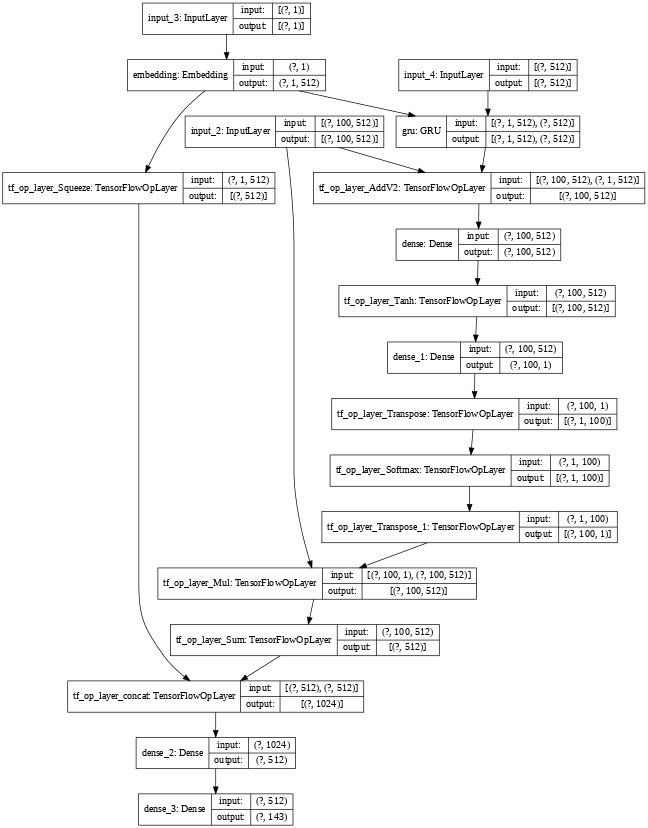

In [ ]:
decoder = create_decoder()

tf.keras.utils.plot_model(decoder, show_shapes=True, dpi = 49)

# Custom Loss Function


In [ ]:
def loss_fn(real, pred):
  # Word Loss

  real_onehot = tf.one_hot(tf.cast(real, tf.uint8), vocab_size)

  loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=False, reduction = 'none', label_smoothing=0.2)
  mask = tf.math.logical_not(tf.math.equal(real, tokenizer.word2index['<pad>'])) # make padding element -> true(1) -> false (0)
  loss_ = loss_object(real_onehot, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  # EOS Loss
  loss_object2 = tf.keras.losses.BinaryCrossentropy(from_logits=False, label_smoothing=0.2)

  end_token = tokenizer.word2index['<end>']
  pred_id = tf.math.argmax(pred, axis=-1)

  real_eos = tf.cast(tf.math.equal(real, end_token), dtype=tf.float32)
  pred_eos = tf.cast(tf.math.equal(pred_id, end_token), dtype=tf.float32)

  loss_2 = loss_object2(real_eos, pred_eos)

  return tf.reduce_mean(loss_) + loss_2 

# Metrics

## NLTK

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

class Bleu(tf.keras.metrics.Metric):
  def __init__(self, name='bleu', **kwargs):
    super(Bleu, self).__init__(name=name, **kwargs)
    self.score = self.add_weight(name='score', initializer='zeros')
    self.count = self.add_weight(name='count', initializer='zeros')
    self.chencherry = SmoothingFunction()

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_true = y_true[y_true != tokenizer.word2index['<pad>']]
    idx = np.where(y_pred == tokenizer.word2index['<end>'])[0]

    if idx != []:
      y_pred = y_pred[:idx[0]+1]
          
    values = sentence_bleu([y_true], y_pred, smoothing_function=self.chencherry.method4)

    self.count.assign_add(1)
    self.score.assign_add(values)

  def result(self):
    return self.score / self.count

  def reset_states(self):
    self.count.assign(0)
    self.score.assign(0)

# Callback

In [ ]:
class EarlyStopping():
  def __init__(self, monitor = 'val_bleu', mode = 'max', patience = 1, encoder = encoder, decoder = decoder):
    if mode == 'max':
      self.mode = 'max'
      self.best = -100
    else: # Min
      self.min = 'min'
      self.best = 100
    self.patience = patience
    self.wait = 0
    self.encoder = encoder
    self.decoder = decoder

  def callback(self, log, epoch):
    if self.mode == 'max':
      if log < self.best:
        self.wait += 1
        if self.wait > self.patience:
          print('EarlyStopping : {} < best {} '.format(log, self.best))
          return True
      else :
        self.wait = 0
        self.best = log
        self.encoder.save(f'Encoder_model{epoch}.h5', include_optimizer=False)
        self.decoder.save(f'Decoder_model{epoch}.h5', include_optimizer=False)
        print('Save Model Succesful')
    else:
      if log > self.best:
        self.wait += 1
        if self.wait > self.patience:
          print('EarlyStopping : {} > best {} '.format(log, self.best))
          return True
      else :
        self.wait = 0
        self.best = log
        self.encoder.save(f'Encoder_model{epoch}.h5', include_optimizer=False)
        self.decoder.save(f'Decoder_model{epoch}.h5', include_optimizer=False)
        print('Save Model Succesful')
    
    return False
  

In [ ]:
earlystop = EarlyStopping(patience = 7)

# Training Model

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.0001, decay_steps = 10000, decay_rate=0.96, staircase=True, name=None
)
opt = tf.keras.optimizers.Adam(lr_schedule)

train_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
val_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')
bleu = Bleu()
bleu_val = Bleu()

## Train Step

In [ ]:
@tf.function
def train_step(img_tensor, target):
  batch_size = tf.shape(img_tensor)[0]

  hidden_state = reset_state(batch_size = batch_size)
  decoder_input = tf.ones([batch_size, 1])
  dec_train_pred = tf.ones([batch_size, 1], dtype=tf.int32)

  loss = 0 
  
  with tf.GradientTape() as tape:
    img_feature = encoder(img_tensor, training = True)

    for i in range(1, max_length_train):
      # passing the features through the decoder
      predictions, hidden_state, _ = decoder([img_feature, decoder_input, hidden_state], training = True)
      loss += loss_fn(target[:,i], predictions)
      
      predict_ids = tf.argmax(predictions, axis = -1, output_type= tf.int32)
      predict_ids = tf.reshape(predict_ids, (-1, 1))
      dec_train_pred = tf.concat( [dec_train_pred, predict_ids], axis = -1 )
      # using teacher forcing
      decoder_input = tf.expand_dims(target[:, i], 1)
      # Metrics
      mask = tf.math.logical_not(tf.math.equal(target[:, i], tokenizer.word2index['<pad>']))
      mask = tf.cast(mask, tf.float32)
      train_acc.update_state(target[:, i], predictions, sample_weight = mask)

  gradient = tape.gradient(loss, encoder.trainable_variables + decoder.trainable_variables) 
  opt.apply_gradients(zip(gradient, encoder.trainable_variables + decoder.trainable_variables))

  return {'pred': dec_train_pred, 'loss': loss / max_length_train, 'acc' : train_acc.result()}

## Test Step

In [ ]:
@tf.function
def test_step(img_tensor, target):
  batch_size = tf.shape(img_tensor)[0]

  hidden_state = reset_state(batch_size = batch_size)
  decoder_input = tf.ones([batch_size, 1])
  dec_val_pred = tf.ones([batch_size, 1], dtype=tf.int32)

  loss = 0

  with tf.GradientTape() as tape:  
    img_feature = encoder(img_tensor, training = False)

    for i in range(1, max_length_test):
      predictions, hidden_state, _ = decoder([img_feature, decoder_input, hidden_state], training = False)
      loss += loss_fn(target[:,i], predictions)

      predict_ids = tf.argmax(predictions, axis = -1, output_type= tf.int32)
      predict_ids = tf.reshape(predict_ids, (-1, 1))
      dec_val_pred = tf.concat( [dec_val_pred, predict_ids], axis = -1 )
        
      decoder_input = tf.expand_dims(target[:, i], 1)

      # Metrics
      mask = tf.math.logical_not(tf.math.equal(target[:, i], tokenizer.word2index['<pad>']))
      mask = tf.cast(mask, tf.float32)
      val_acc.update_state(target[:, i], predictions, sample_weight = mask)

  return {'pred': dec_val_pred, 'loss': loss/max_length_test, 'acc': val_acc.result()}

In [ ]:
from IPython.display import clear_output, display

def fit(epochs, dataset, dataset_val, num_steps, num_steps_val):
  for epoch in trange(1, epochs+1):
    train_acc.reset_states()
    bleu.reset_states()

    for index, (image, caption) in tqdm(enumerate(dataset.take(num_steps)), total=num_steps, leave=False):
      monitor = train_step(image, caption)
  
      for i in range(tf.shape(caption)[0]):
        bleu.update_state(caption[i].numpy(), monitor['pred'][i].numpy())

    val_acc.reset_states()
    bleu_val.reset_states()

    for index, (image, caption) in tqdm(enumerate(dataset_val.take(num_steps_val)), total=num_steps_val, leave=False):
      monitor_val = test_step(image, caption)

      for i in range(tf.shape(caption)[0]):
        bleu_val.update_state(caption[i].numpy(), monitor_val['pred'][i].numpy())
            
    print(f'Epoch {epoch}/{epochs}\n'\
          f'loss : {(monitor["loss"].numpy()):.4f} acc : {(monitor["acc"].numpy()):.4f} bleu : {(bleu.result().numpy()):.4f} '\
          f'val_loss : {(monitor_val["loss"].numpy()):.4f} val_acc : {(monitor_val["acc"].numpy()):.4f} val_bleu : {(bleu_val.result().numpy()):.4f}'
    )

    if earlystop.callback(bleu_val.result().numpy(), epoch):
      break

    del monitor
    del monitor_val

## Fitting

In [ ]:
fit(epochs = 50, dataset = dataset, num_steps = num_steps_train,
    dataset_val = dataset_val, num_steps_val = num_steps_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


Epoch 1/50
loss : 2.6042 acc : 0.1948 bleu : 0.1967 val_loss : 3.4736 val_acc : 0.2026 val_bleu : 0.2224
Save Model Succesful


Epoch 2/50
loss : 2.5577 acc : 0.2133 bleu : 0.1969 val_loss : 3.4242 val_acc : 0.2043 val_bleu : 0.2223


Epoch 3/50
loss : 2.7932 acc : 0.2753 bleu : 0.1668 val_loss : 3.8485 val_acc : 0.3211 val_bleu : 0.1984


Epoch 4/50
loss : 3.3809 acc : 0.3698 bleu : 0.2024 val_loss : 3.8263 val_acc : 0.3888 val_bleu : 0.2296
Save Model Succesful


Epoch 5/50
loss : 7.9270 acc : 0.4323 bleu : 0.2360 val_loss : 4.4813 val_acc : 0.4315 val_bleu : 0.2414
Save Model Succesful


Epoch 6/50
loss : 8.7146 acc : 0.4715 bleu : 0.2449 val_loss : 7.0474 val_acc : 0.4705 val_bleu : 0.2531
Save Model Succesful


Epoch 7/50
loss : 7.3558 acc : 0.4912 bleu : 0.2474 val_loss : 6.5150 val_acc : 0.4948 val_bleu : 0.2604
Save Model Succesful


Epoch 8/50
loss : 5.3801 acc : 0.5091 bleu : 0.2502 val_loss : 6.7046 val_acc : 0.5039 val_bleu : 0.2659
Save Model Succesful


Epoch 9/50
loss : 8.0477 acc : 0.5096 bleu : 0.2569 val_loss : 7.0832 val_acc : 0.4827 val_bleu : 0.2594


Epoch 10/50
loss : 5.4720 acc : 0.5360 bleu : 0.2643 val_loss : 6.8021 val_acc : 0.5190 val_bleu : 0.2864
Save Model Succesful


Epoch 11/50
loss : 3.9818 acc : 0.5489 bleu : 0.2809 val_loss : 5.7839 val_acc : 0.5315 val_bleu : 0.2920
Save Model Succesful


Epoch 12/50
loss : 4.7154 acc : 0.5631 bleu : 0.2963 val_loss : 3.7112 val_acc : 0.5308 val_bleu : 0.2609


Epoch 13/50
loss : 7.1873 acc : 0.5744 bleu : 0.3082 val_loss : 5.0976 val_acc : 0.5459 val_bleu : 0.2953
Save Model Succesful


Epoch 14/50
loss : 7.7672 acc : 0.5900 bleu : 0.3191 val_loss : 4.8269 val_acc : 0.5507 val_bleu : 0.3048
Save Model Succesful


Epoch 15/50
loss : 7.2070 acc : 0.6040 bleu : 0.3269 val_loss : 5.4851 val_acc : 0.5493 val_bleu : 0.3031


Epoch 16/50
loss : 7.7911 acc : 0.6152 bleu : 0.3379 val_loss : 5.2947 val_acc : 0.5470 val_bleu : 0.2982


Epoch 17/50
loss : 8.0999 acc : 0.6266 bleu : 0.3504 val_loss : 4.7808 val_acc : 0.5520 val_bleu : 0.2991


Epoch 18/50
loss : 5.6010 acc : 0.6369 bleu : 0.3627 val_loss : 6.6289 val_acc : 0.5668 val_bleu : 0.3088
Save Model Succesful


Epoch 19/50
loss : 4.3252 acc : 0.6442 bleu : 0.3567 val_loss : 4.6739 val_acc : 0.5604 val_bleu : 0.2937


Epoch 20/50
loss : 5.3068 acc : 0.6534 bleu : 0.3769 val_loss : 4.4344 val_acc : 0.5584 val_bleu : 0.2895


Epoch 21/50
loss : 5.9550 acc : 0.6668 bleu : 0.3812 val_loss : 5.4359 val_acc : 0.5645 val_bleu : 0.2935


Epoch 22/50
loss : 4.9666 acc : 0.6676 bleu : 0.3756 val_loss : 4.8603 val_acc : 0.5682 val_bleu : 0.2836


Epoch 23/50
loss : 6.5498 acc : 0.6730 bleu : 0.3763 val_loss : 4.6111 val_acc : 0.5732 val_bleu : 0.3030


Epoch 24/50
loss : 7.9619 acc : 0.6798 bleu : 0.3823 val_loss : 7.0449 val_acc : 0.5688 val_bleu : 0.3142
Save Model Succesful


Epoch 25/50
loss : 6.5938 acc : 0.6827 bleu : 0.3611 val_loss : 6.7737 val_acc : 0.5725 val_bleu : 0.3153
Save Model Succesful


Epoch 26/50
loss : 6.1056 acc : 0.6920 bleu : 0.3712 val_loss : 7.2229 val_acc : 0.5746 val_bleu : 0.3165
Save Model Succesful


Epoch 27/50
loss : 7.7832 acc : 0.6986 bleu : 0.3711 val_loss : 8.5774 val_acc : 0.5698 val_bleu : 0.3166
Save Model Succesful


Epoch 28/50
loss : 6.2524 acc : 0.7020 bleu : 0.3766 val_loss : 8.0840 val_acc : 0.5709 val_bleu : 0.3208
Save Model Succesful


Epoch 29/50
loss : 2.9907 acc : 0.7085 bleu : 0.3863 val_loss : 4.7826 val_acc : 0.5779 val_bleu : 0.3157


Epoch 30/50
loss : 3.6926 acc : 0.7168 bleu : 0.4016 val_loss : 4.7812 val_acc : 0.5877 val_bleu : 0.3044


Epoch 31/50
loss : 5.4242 acc : 0.7295 bleu : 0.4109 val_loss : 5.6471 val_acc : 0.5799 val_bleu : 0.3148


Epoch 32/50
loss : 4.8051 acc : 0.7299 bleu : 0.4230 val_loss : 5.9358 val_acc : 0.5799 val_bleu : 0.3274
Save Model Succesful


Epoch 33/50
loss : 4.0612 acc : 0.7430 bleu : 0.4324 val_loss : 6.0012 val_acc : 0.5890 val_bleu : 0.3184


Epoch 34/50
loss : 4.9645 acc : 0.7424 bleu : 0.4355 val_loss : 6.1661 val_acc : 0.5890 val_bleu : 0.3253


Epoch 35/50
loss : 4.4742 acc : 0.7570 bleu : 0.4471 val_loss : 6.6217 val_acc : 0.5887 val_bleu : 0.3325
Save Model Succesful


Epoch 36/50
loss : 5.8952 acc : 0.7646 bleu : 0.4638 val_loss : 6.2188 val_acc : 0.5863 val_bleu : 0.3300


Epoch 37/50
loss : 4.7212 acc : 0.7638 bleu : 0.4597 val_loss : 6.1142 val_acc : 0.5863 val_bleu : 0.3251


Epoch 38/50
loss : 5.2673 acc : 0.7685 bleu : 0.4600 val_loss : 6.2905 val_acc : 0.5954 val_bleu : 0.3349
Save Model Succesful


Epoch 39/50
loss : 5.0799 acc : 0.7860 bleu : 0.5050 val_loss : 5.6036 val_acc : 0.5978 val_bleu : 0.3214


Epoch 40/50
loss : 4.9462 acc : 0.7807 bleu : 0.4705 val_loss : 5.6291 val_acc : 0.5978 val_bleu : 0.3266


Epoch 41/50
loss : 5.0537 acc : 0.7854 bleu : 0.4888 val_loss : 5.7922 val_acc : 0.5991 val_bleu : 0.3272


Epoch 42/50
loss : 5.7311 acc : 0.7943 bleu : 0.5011 val_loss : 5.7860 val_acc : 0.5971 val_bleu : 0.3152


Epoch 43/50
loss : 5.2311 acc : 0.7989 bleu : 0.5095 val_loss : 5.3623 val_acc : 0.5961 val_bleu : 0.3157


Epoch 44/50
loss : 4.5046 acc : 0.8057 bleu : 0.4987 val_loss : 5.8597 val_acc : 0.5985 val_bleu : 0.3224


Epoch 45/50
loss : 4.3365 acc : 0.8083 bleu : 0.5121 val_loss : 4.8824 val_acc : 0.6022 val_bleu : 0.3078


Epoch 46/50
loss : 4.4763 acc : 0.8098 bleu : 0.5010 val_loss : 5.2158 val_acc : 0.6042 val_bleu : 0.3019
EarlyStopping : 0.30185434222221375 < best 0.33487311005592346 


# Load Best Model

In [ ]:
# encoder.save('encoder_model.h5', include_optimizer=False)
# decoder.save('decoder_model.h5', include_optimizer=False)

encoder = tf.keras.models.load_model('Encoder_model6.h5')
decoder = tf.keras.models.load_model('Decoder_model6.h5')

# Caption It

In [ ]:
from nami.AI.kme_tokenize import Segmentation
kme_segment = Segmentation()

In [ ]:
def evaluate(image, max_length):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden_state = reset_state(batch_size = 1)

    image = tf.reshape(image, shape=(1,image.shape[0],image.shape[1],image.shape[2]))
    image = tf.cast(image, tf.float32)
    features = encoder( image, training = False )

    dec_input = tf.expand_dims([tokenizer.word2index['<start>']], 0)
    result = []

    for i in range(max_length): # *

        predictions, hidden_state, attention_weights = decoder([features, dec_input, hidden_state], training = False)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = np.argmax(predictions, axis=-1)[0]

        result.append(tokenizer.index2word[predicted_id])

        if tokenizer.index2word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):

    fig = plt.figure(figsize=(12, 12))
    fig.suptitle(''.join(result[:-1]), fontsize=22, y = 1.03)
    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot((len_result//2)+1, (len_result//2)+1, l+1)
        ax.set_title(result[l])
        img = ax.imshow(image)
        ax.imshow(temp_att, cmap='binary', alpha=0.5, extent=img.get_extent())
    
    plt.tight_layout()
    plt.show()

Real Caption: deca-2,8-diyne
Prediction Caption: 1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1


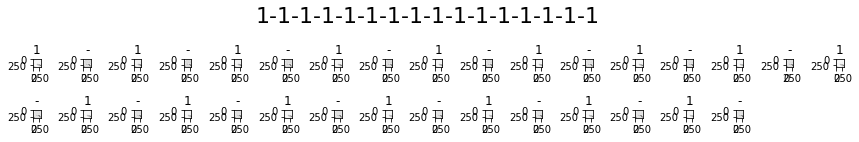

In [ ]:
# captions on the validation set
result, attention_plot = evaluate(image_train[1], max_length_test)

print ('Real Caption:', caption_train[1])
print ('Prediction Caption:', ''.join(result[:-1]))

plot_attention(image_train[1], result, attention_plot)

# WER, MER, WIL, WIP

- WER = Word Error Rate
- MER = Match Error Rate
- WIL = Word Information Lost
- WIP = Word Information Preserved

In [ ]:
!pip install jiwer

     |████████████████████████████████| 51kB 5.0MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.0-cp36-cp36m-linux_x86_64.whl size=144802 sha256=5b5bfe841d1976c65107b73520d330265720c678d1ec855a70866282bd1ac5ba
  Stored in directory: /root/.cache/pip/wheels/de/c2/93/660fd5f7559049268ad2dc6d81c4e39e9e36518766eaf7e342
Successfully built python-Levenshtein


In [ ]:
import jiwer

transformation = jiwer.Compose([
    jiwer.ToLowerCase(),
    jiwer.RemoveMultipleSpaces(),
    jiwer.RemoveWhiteSpace(replace_by_space=False),
    jiwer.SentencesToListOfWords(word_delimiter=" ")
]) 

In [ ]:
ground_truth, _ = kme_segment.word_segmentation(caption_test[0])
hypothesis, _ = evaluate(image_test[0], max_length_test)
score = jiwer.compute_measures(
    ground_truth,
    hypothesis[:-1], 
    truth_transform=transformation, 
    hypothesis_transform=transformation
)

print(ground_truth)
print(hypothesis[:-1])
print(score)

['5', '-', 'eth', 'yl', 'oct', '-', '2', '-', 'yne']
['1', '-', '1', '-', '1', '-', '1', '-', '1', '-', '1', '-', '1', '-', '1', '-', '1', '-', '1', '-', '1', '-', '1', '-', '1', '-', '1', '-', '1', '-', '1']
{'wer': 3.111111111111111, 'mer': 0.9032258064516129, 'wil': 0.967741935483871, 'wip': 0.03225806451612903, 'hits': 3, 'substitutions': 6, 'deletions': 0, 'insertions': 22}


# BLEU SCORE

In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

## All Bleu Score

In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nami.AI.kme_tokenize import Segmentation
from tqdm.notebook import trange
kme_segment = Segmentation()
score1, score2, score3, score4 = [], [], [], []
best_score = {}
chencherry = SmoothingFunction()

for i in trange(len(image_test)):
  word_arr, _ = evaluate(image_test[i], max_length_test)

  real_word,_ = kme_segment.word_segmentation(caption_test[i])

  score1 = np.concatenate((score3, [sentence_bleu([real_word], word_arr[:-1], weights=(1.0, 0, 0, 0), smoothing_function = chencherry.method4)]))
  score2 = np.concatenate((score3, [sentence_bleu([real_word], word_arr[:-1], weights=(0.5, 0.5, 0, 0), smoothing_function = chencherry.method4)]))
  score3 = np.concatenate((score3, [sentence_bleu([real_word], word_arr[:-1], weights=(0.3, 0.3, 0.3, 0), smoothing_function = chencherry.method4)]))
  score4 = np.concatenate((score4, [sentence_bleu([real_word], word_arr[:-1], weights=(0.25, 0.25, 0.25, 0.25), smoothing_function = chencherry.method4)]))

ZeroDivisionError: ignored

In [ ]:
print(f"BLEU1 {np.mean(score1)*100}\n"
      f"BLEU2 {np.mean(score2)*100}\n"
      f"BLEU3 {np.mean(score3)*100}\n"
      f"BLEU4 {np.mean(score4)*100}\n"
      )

In [ ]:
best_score = {}
chencherry = SmoothingFunction()

for i in trange(len(image_test)):
  word_arr, _ = evaluate(image_test[i], max_length_test)
  real_word,_ = kme_segment.word_segmentation(caption_test[i])

  score = sentence_bleu([real_word], word_arr[:-1], smoothing_function = chencherry.method4)
  best_score[i] = score
  #print(f"{i} | {score:.4f}", end=' ')
  #print(''.join(word_arr[:-1]), end=' : ')
  #print(caption_test[i])

In [ ]:
sort_best_score = sorted(best_score.items(), key=lambda x: x[1], reverse=True)

In [ ]:
for i in range(30):
  print(sort_best_score[i][0], sort_best_score[i][1])

# Example

In [ ]:
# captions on the validation set
result, attention_plot = evaluate(image_test[33], max_length_test)

print ('Real Caption:', caption_test[33])
print ('Prediction Caption:', ''.join(result[:-1]))
plt.imshow(image_test[33])
plt.show()
plot_attention(image_test[33], result, attention_plot)


In [ ]:
# captions on the validation set
result, attention_plot = evaluate(image_test[38], max_length_test)

print ('Real Caption:', caption_test[38])
print ('Prediction Caption:', ''.join(result[:-1]))
plt.imshow(image_test[38])
plt.show()
plot_attention(image_test[38], result, attention_plot)


In [ ]:
# captions on the validation set
result, attention_plot = evaluate(image_train[282], max_length_train)

print ('Real Caption:', caption_train[282])
print ('Prediction Caption:', ''.join(result[:-1]))
plt.imshow(image_train[282])
plt.show()
plot_attention(image_train[282], result, attention_plot)


In [ ]:
plt.imshow(image_train[0,:,:,0], cmap='gray')

In [ ]:
# captions on the validation set
result, attention_plot = evaluate(image_test[270], max_length_test)

print ('Real Caption:', caption_test[270])
print ('Prediction Caption:', ''.join(result[:-1]))
plt.imshow(image_test[270])
plt.show()
plot_attention(image_test[270], result, attention_plot)
